In [1]:
from time import perf_counter_ns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from adaptvqe.pools import FullPauliPool, TiledPauliPool
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt
from adaptvqe.hamiltonians import XXZHamiltonian

In [2]:
dmrg_mpo_bond = 100
dmrg_mps_bond = 10
pool_mpo_bond = 100
adapt_mpo_bond = 100
adapt_mps_bond = 10

system_sizes = list(range(2, 12, 2))

In [3]:
linalg_times = {}
tn_times = {}

for l in system_sizes:
    print(f"l = {l}")
    j_xy = 1
    j_z = 1
    h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=dmrg_mpo_bond, max_mps_bond=dmrg_mps_bond)
    pool = FullPauliPool(n=l)

    # Generate indices and coefficients randomly.
    inds = np.random.randint(0, len(pool.operators), size=10)
    coeffs = np.random.rand(len(inds))

    start_time = perf_counter_ns()
    linalg_adapt = LinAlgAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    state = linalg_adapt.compute_state(coefficients=coeffs, indices=inds)
    end_time = perf_counter_ns()
    linalg_times[l] = end_time - start_time

    start_time = perf_counter_ns()
    tn_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    state = tn_adapt.compute_state(coefficients=coeffs, indices=inds)
    end_time = perf_counter_ns()
    tn_times[l] = end_time - start_time

l = 2
No pre-computed energy for given parameters.
Solving by DMRG with quimb.
Conversion took 1.66334e+05 ns.
Multiplication took 5.70583e+05 ns.
Conversion took 1.11625e+05 ns.
Multiplication took 3.91042e+05 ns.
Conversion took 7.73750e+04 ns.
Multiplication took 3.01542e+05 ns.
Conversion took 6.59170e+04 ns.
Multiplication took 4.45042e+05 ns.
Conversion took 1.15792e+05 ns.
Multiplication took 3.91458e+05 ns.
Conversion took 9.98750e+04 ns.
Multiplication took 3.49209e+05 ns.
Conversion took 7.35420e+04 ns.
Multiplication took 3.39292e+05 ns.
Conversion took 2.09000e+02 ns.
Multiplication took 2.76958e+05 ns.
Conversion took 6.90000e+04 ns.
Multiplication took 2.73958e+05 ns.
Conversion took 1.25000e+02 ns.
Multiplication took 2.74792e+05 ns.
l = 4
Conversion took 1.04750e+05 ns.
Multiplication took 6.78083e+05 ns.
Conversion took 1.12084e+05 ns.
Multiplication took 7.26500e+05 ns.
Conversion took 1.02458e+05 ns.
Multiplication took 6.92250e+05 ns.
Conversion took 1.12709e+05 ns.

/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality contraction paths.
  warnings.warn(


Conversion took 7.44292e+06 ns.
Multiplication took 2.04433e+06 ns.
Conversion took 6.75838e+06 ns.
Multiplication took 1.64262e+06 ns.
Conversion took 6.91079e+06 ns.
Multiplication took 1.41821e+06 ns.
Conversion took 6.36683e+06 ns.
Multiplication took 1.50938e+06 ns.
Conversion took 5.87500e+06 ns.
Multiplication took 1.48083e+06 ns.
Conversion took 5.96500e+06 ns.
Multiplication took 1.37625e+06 ns.
Conversion took 5.80338e+06 ns.
Multiplication took 2.40546e+06 ns.
Conversion took 5.93471e+06 ns.
Multiplication took 1.56138e+06 ns.
Conversion took 5.57871e+06 ns.
Multiplication took 1.59779e+06 ns.
Conversion took 5.36717e+06 ns.
Multiplication took 1.50262e+06 ns.
l = 10
Conversion took 1.20980e+08 ns.
Multiplication took 1.73725e+06 ns.
Conversion took 1.18872e+08 ns.
Multiplication took 1.78300e+06 ns.
Conversion took 1.19252e+08 ns.
Multiplication took 1.78408e+06 ns.
Conversion took 1.22064e+08 ns.
Multiplication took 1.89979e+06 ns.
Conversion took 1.19705e+08 ns.
Multiplic

In [4]:
records = []
for l in system_sizes:
    records.append((l, linalg_times[l], tn_times[l]))
df = pd.DataFrame.from_records(records, columns=["l", "linalg_time", "tn_time"])
df.set_index("l", inplace=True)

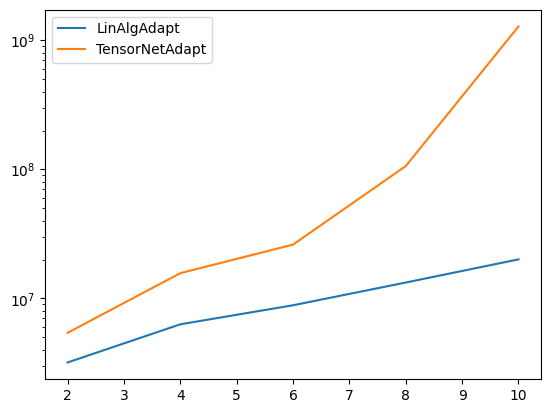

In [5]:
fig, ax = plt.subplots()
ax.plot(df.index, df["linalg_time"], label="LinAlgAdapt")
ax.plot(df.index, df["tn_time"], label="TensorNetAdapt")
ax.set_yscale("log")
ax.legend()

## Try with repeated indices

If indices are repeated, with the new method, subsequent call to `tn_expm_mult_state` _should_ be faster.

In [6]:
linalg_times = {}
tn_times = {}

for l in system_sizes:
    print(f"l = {l}")
    j_xy = 1
    j_z = 1
    h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=dmrg_mpo_bond, max_mps_bond=dmrg_mps_bond)
    pool = FullPauliPool(n=l)

    # Generate indices and coefficients randomly.
    inds = np.array([2] * 10, dtype=int)
    coeffs = np.random.rand(len(inds))

    start_time = perf_counter_ns()
    linalg_adapt = LinAlgAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    state = linalg_adapt.compute_state(coefficients=coeffs, indices=inds)
    end_time = perf_counter_ns()
    linalg_times[l] = end_time - start_time

    start_time = perf_counter_ns()
    tn_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    state = tn_adapt.compute_state(coefficients=coeffs, indices=inds)
    end_time = perf_counter_ns()
    tn_times[l] = end_time - start_time

l = 2
No pre-computed energy for given parameters.
Solving by DMRG with quimb.
Conversion took 2.31166e+05 ns.
Multiplication took 9.30542e+05 ns.
Conversion took 3.33000e+02 ns.
Multiplication took 6.30500e+05 ns.
Conversion took 3.34000e+02 ns.
Multiplication took 4.92958e+05 ns.
Conversion took 2.08000e+02 ns.
Multiplication took 5.33209e+05 ns.
Conversion took 1.67000e+02 ns.
Multiplication took 3.75167e+05 ns.
Conversion took 1.66000e+02 ns.
Multiplication took 3.84500e+05 ns.
Conversion took 1.66000e+02 ns.
Multiplication took 3.34042e+05 ns.
Conversion took 1.25000e+02 ns.
Multiplication took 2.90542e+05 ns.
Conversion took 1.67000e+02 ns.
Multiplication took 2.91167e+05 ns.
Conversion took 1.67000e+02 ns.
Multiplication took 2.89833e+05 ns.
l = 4
Conversion took 1.12916e+05 ns.
Multiplication took 6.99250e+05 ns.
Conversion took 2.50000e+02 ns.
Multiplication took 6.51292e+05 ns.
Conversion took 1.67000e+02 ns.
Multiplication took 6.46875e+05 ns.
Conversion took 1.67000e+02 ns.